In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt

from abc import abstractmethod, ABC
from typing import Sequence, Optional, Literal, Callable

from numpy.typing import NDArray

np.random.seed(1234)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

### Handy utility functions

In [2]:
# def append_ones(matrix, axis=1):
#     return np.concatenate((matrix, np.ones((matrix.shape[0], 1), dtype=np.float32)), axis=axis)


def zeros(*dims: int) -> NDArray:
    return np.zeros(shape=tuple(dims), dtype=np.float32)


def ones(*dims: int) -> NDArray:
    return np.ones(shape=tuple(dims), dtype=np.float32)


def rand(*dims: int) -> NDArray:
    return np.random.rand(*dims).astype(np.float32)


def randn(*dims: int) -> NDArray:
    return np.random.randn(*dims).astype(np.float32)


def chunks(seq: NDArray, size: int):
    return (seq[pos : pos + size] for pos in range(0, len(seq), size))


def as_matrix(vector: NDArray) -> NDArray:
    return np.reshape(vector, (-1, 1))


def one_hot_encode(labels: NDArray) -> NDArray:
    one_hot = zeros(labels.shape[0], np.max(labels) + 1)
    one_hot[np.arange(labels.shape[0]), labels] = 1
    return one_hot.astype(np.float32)


def tiles(examples: NDArray):
    space = 2
    rows, cols, h, w = examples.shape

    img_matrix = np.empty(shape=(rows * (h + space) - space, cols * (h + space) - space))
    img_matrix.fill(np.nan)

    for r in range(rows):
        for c in range(cols):
            x_0 = r * (h + space)
            y_0 = c * (w + space)
            ex_min = np.min(examples[r, c])
            ex_max = np.max(examples[r, c])
            img_matrix[x_0 : x_0 + h, y_0 : y_0 + w] = (examples[r, c] - ex_min) / (ex_max - ex_min)

    plt.matshow(img_matrix, cmap="gray", interpolation="none")
    plt.axis("off")
    plt.show()

### Activation functions

In [3]:
def sigmoid(x: NDArray, sample: bool = False) -> NDArray:
    σ = 1.0 / (1.0 + np.exp(-x))
    if sample:
        return σ > rand(*σ.shape)
    return σ

In [4]:
def gaussian(x: NDArray, sample: bool) -> NDArray:
    if sample:
        return x + randn(*x.shape)
    return x

# MNIST dataset

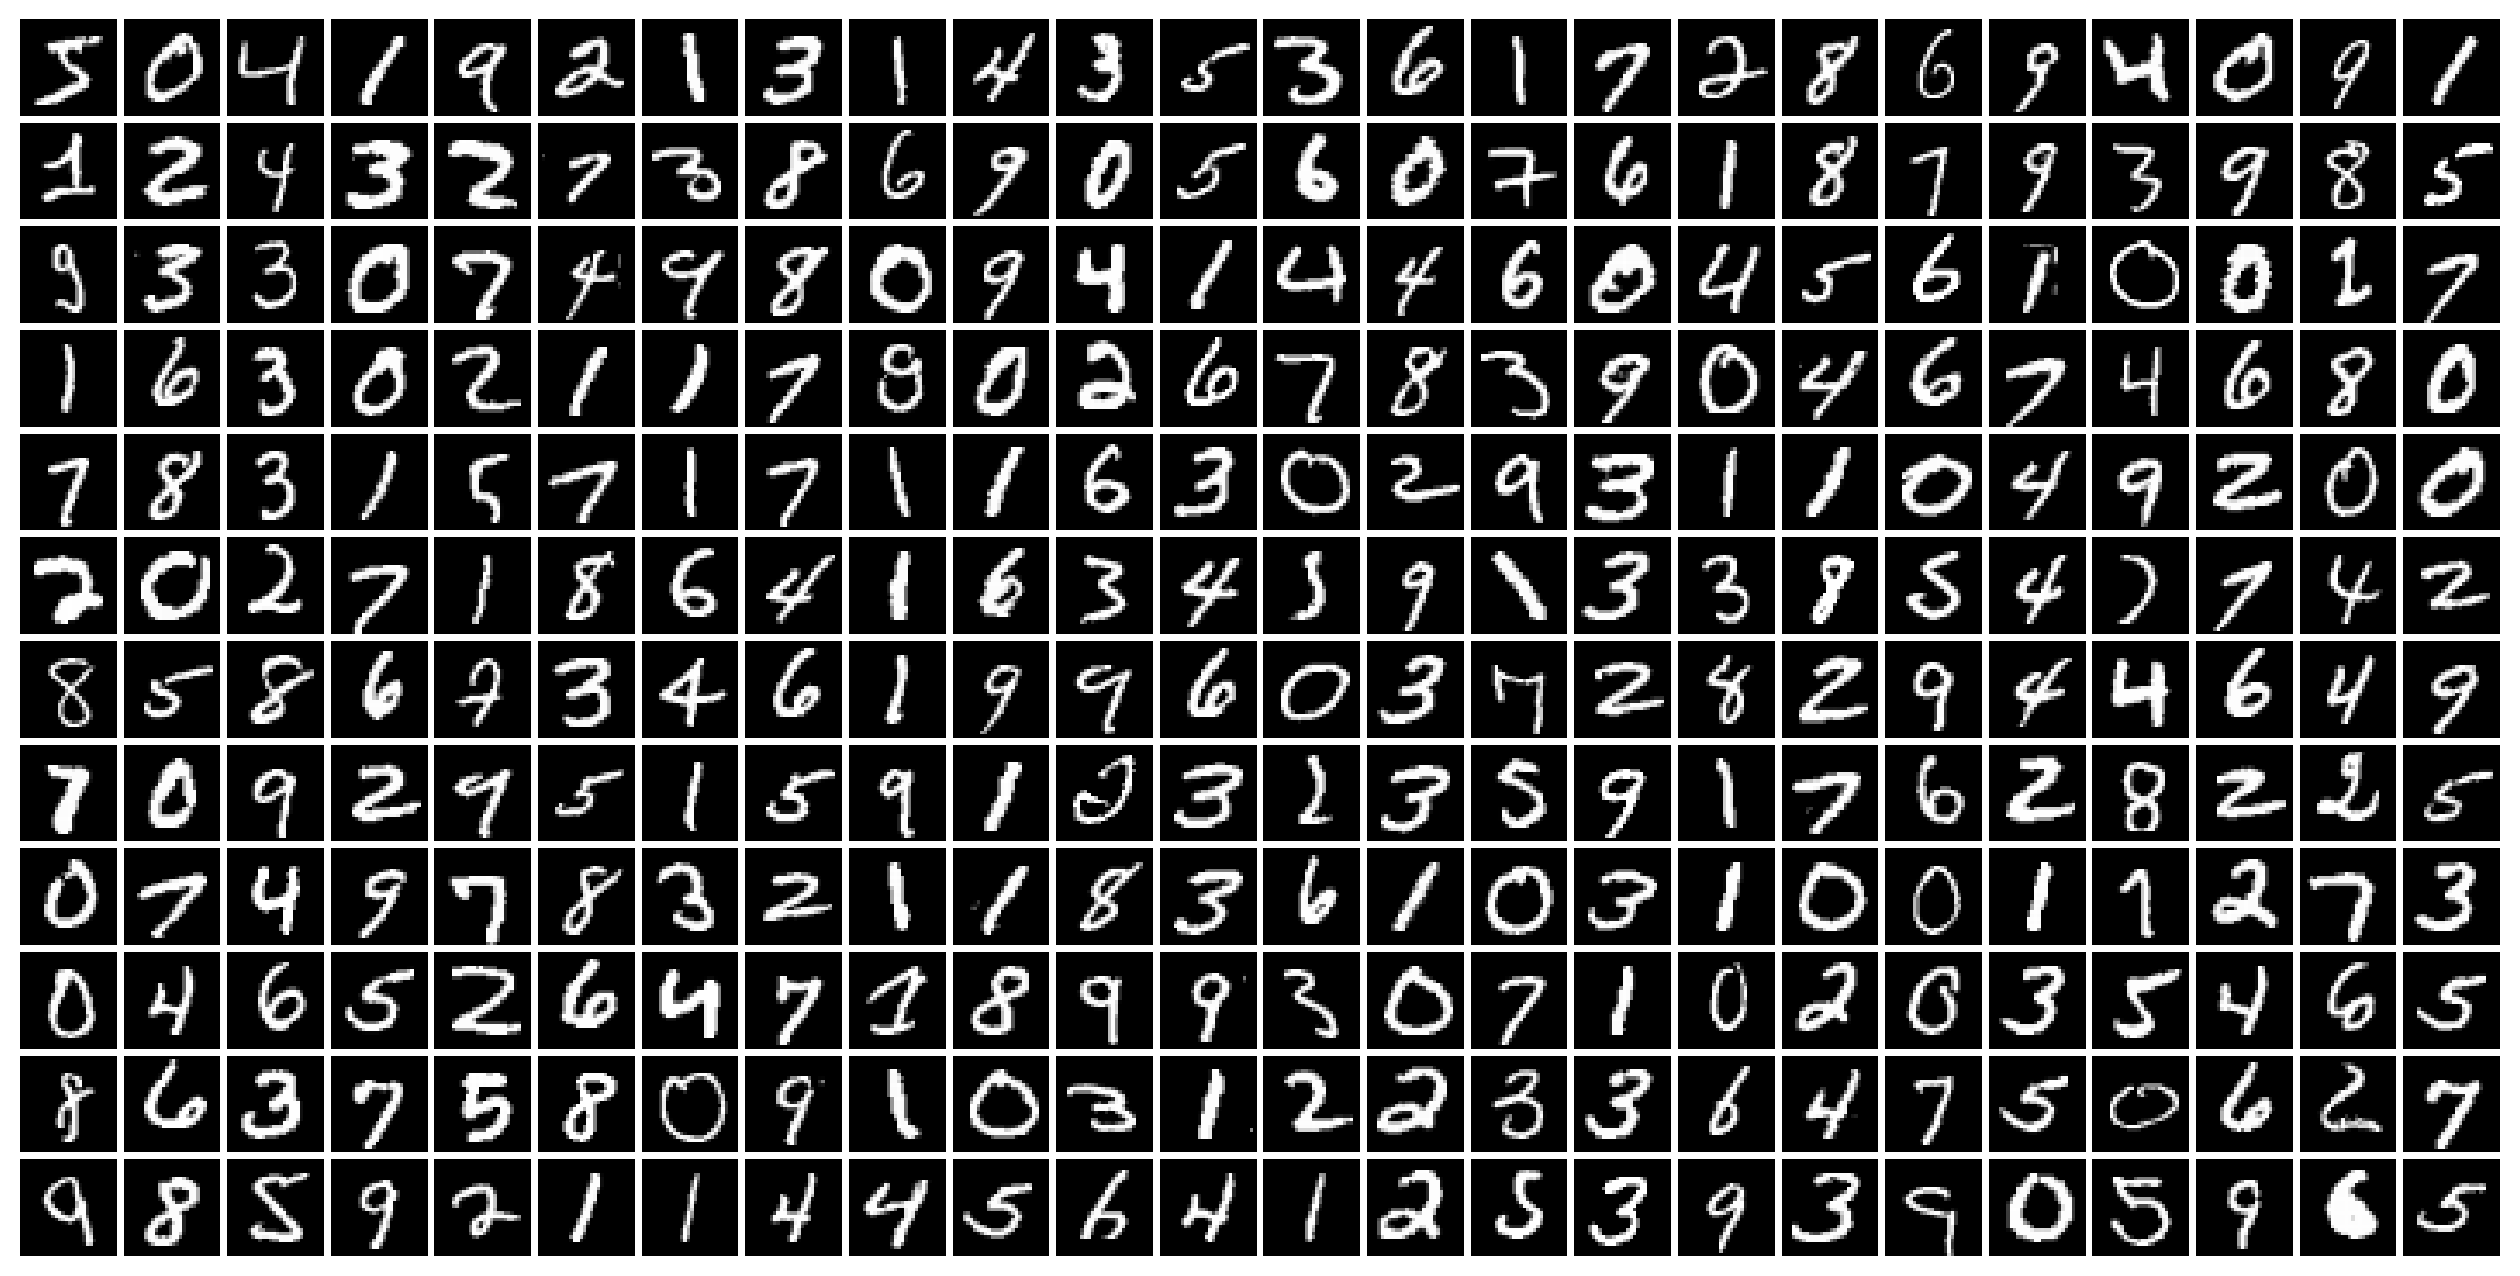

In [5]:
from mnists import MNIST

mnist = MNIST()
digits = mnist.train_images()
digits = digits[: 12 * 24]
digits = digits.reshape(-1, 24, 28, 28)
tiles(digits)

# RBM & DBN training

In [6]:
class RBM:
    def __init__(
        self,
        vsize: int,
        hsize: int,
        v_activation: Callable[[NDArray, bool], NDArray],
        h_activation: Callable[[NDArray, bool], NDArray],
        lr: float,
        momentum: float,
        l2_penalty: float,
        init_method: Literal["Xavier", "He"],
    ):
        self.vsize = vsize
        self.hsize = hsize
        self.v_activation = v_activation
        self.h_activation = h_activation

        # Training hyper-params
        self.lr = lr
        self.momentum = momentum
        self.l2_penalty = l2_penalty

        # Initialize
        self.init_method = init_method
        self.reset()

    def reset(self):
        # Weights initialization
        match self.init_method:
            case "Xavier":
                scale = np.sqrt(6 / (self.vsize + self.hsize))
                self.w = np.random.uniform(-scale, +scale, size=(self.vsize, self.hsize)).astype(np.float32)
            case "He":
                scale = np.sqrt(4 / (self.vsize + self.hsize))
                self.w = np.random.normal(0, scale, size=(self.vsize, self.hsize)).astype(np.float32)
            case _:
                raise ValueError(f"Unrecognised `init_method`: {self.init_method}")

        # Bias initialization
        self.b = zeros(self.vsize)
        self.c = zeros(self.hsize)

        # Velocity (momentum) tensor initialization
        self.m_w = zeros(self.vsize, self.hsize)
        self.m_b = zeros(self.vsize)
        self.m_c = zeros(self.hsize)

    def probas_v(self, h: NDArray, sample: bool) -> NDArray:
        return self.v_activation(self.b + h @ self.w.T, sample=sample)

    def probas_h(self, v: NDArray, sample: bool) -> NDArray:
        return self.h_activation(self.c + v @ self.w, sample=sample)

    def sample(self, v: NDArray, steps: int) -> NDArray:
        # --- Gibbs sampling
        for k in range(steps):
            h = self.probas_h(v, sample=True)
            v = self.probas_v(h, sample=(k < steps - 1))
        return v

In [7]:
def reconstuction_error(rbm: RBM, v: NDArray) -> float:
    batch_size = v.shape[0]
    σ = rbm.sample(v, steps=1)
    return 1 / batch_size * np.sum((v - σ) ** 2)


def draw_rbm_filters(rbm: RBM):
    filters = rbm.w.T
    filters = filters.reshape(8, -1, 28, 28)
    tiles(filters)

In [8]:
def cdk(rbm: RBM, minibatch: NDArray, k: int = 1):
    batch_size = minibatch.shape[0]
    v = minibatch

    # Compute gradients
    # -----------------

    # Positive phase
    σ = rbm.probas_h(v, sample=False)

    grad_w = -1 / batch_size * (v.T @ σ)
    grad_b = -1 / batch_size * (v.sum(axis=0))
    grad_c = -1 / batch_size * (σ.sum(axis=0))

    # Negative phase

    # --- Gibbs sampling
    h = rbm.probas_h(v, sample=True)
    v = rbm.probas_v(h, sample=True)
    for _ in range(k - 1):
        h = rbm.probas_h(v, sample=True)
        v = rbm.probas_v(h, sample=True)

    # --- Negative gradient estimation
    σ = rbm.probas_h(v, sample=False)

    grad_w += 1 / batch_size * (v.T @ σ)
    grad_b += 1 / batch_size * (v.sum(axis=0))
    grad_c += 1 / batch_size * (σ.sum(axis=0))

    # Apply L2 regularization
    # -----------------------
    grad_w += rbm.l2_penalty * rbm.w

    # Update params
    # -------------
    rbm.m_w = rbm.momentum * rbm.m_w - rbm.lr * grad_w
    rbm.m_b = rbm.momentum * rbm.m_b - rbm.lr * grad_b
    rbm.m_c = rbm.momentum * rbm.m_c - rbm.lr * grad_c

    rbm.w += rbm.m_w
    rbm.b += rbm.m_b
    rbm.c += rbm.m_c

In [9]:
def propagate_up(dbn: Sequence[RBM], n_layers: int, v: NDArray) -> NDArray:
    assert 0 <= n_layers < len(dbn)
    for i in range(n_layers):
        v = dbn[i].probas_h(v, sample=False)
    return v


def propagate_dn(dbn: Sequence[RBM], n_layers: int, h: NDArray) -> NDArray:
    assert 0 <= n_layers < len(dbn)
    for i in reversed(range(n_layers)):
        h = dbn[i].probas_v(h, sample=False)
    return h


def dbn_reconstuction_error(dbn: Sequence[RBM], n_layers: int, minibatch: NDArray) -> float:
    assert 0 <= n_layers < len(dbn)
    visible = propagate_up(dbn, n_layers, minibatch)
    return reconstuction_error(dbn[n_layers], visible)


def train_dbn_layer(dbn: Sequence[RBM], layer_idx: int, dataset: NDArray, batch_size: int):
    dataset = propagate_up(dbn, layer_idx, dataset)
    batches_limit = dataset.shape[0] / batch_size
    for batch_idx, batch in enumerate(chunks(dataset, batch_size)):
        cdk(dbn[layer_idx], batch)
        if batch_idx % round(batches_limit / 40) == 0:
            print("#", end="")


def train_dbn(
    dbn: Sequence[RBM],
    dataset: NDArray,
    monitoring_set: NDArray,
    batch_size: int,
    epochs_count: int,
):
    for layer_idx in range(len(dbn)):
        print("\nLearning layer {}".format(layer_idx))

        for epoch in range(epochs_count):
            print("Epoch {}:".format(epoch + 1), end="\t")

            if epoch == 5:
                dbn[layer_idx].momentum = 0.9

            start_time = time.time()
            train_dbn_layer(dbn, layer_idx, dataset, batch_size)
            elapsed = time.time() - start_time

            error = dbn_reconstuction_error(dbn, layer_idx, monitoring_set)
            print("\telapsed: {0:>2.2f}s, reconstruction error: {1:>2.2f}".format(elapsed, error))

# Autoencoder training

In [10]:
class Layer(ABC):
    # Outputs of the layer after forward pass
    y: Optional[NDArray]

    @abstractmethod
    def reset(self, *args, **kwargs):
        """Initialize the layer."""
        raise NotImplementedError

    @abstractmethod
    def forward(self, x: NDArray, training: bool) -> NDArray:
        """Propagate the input `x` forward through the layer and save the output in `self.y`."""
        raise NotImplementedError

    @abstractmethod
    def backward(self, x: NDArray, grad_y: NDArray) -> NDArray:
        """
        Given layer input `x` and ∂Loss/∂y (`grad_y`)
            * compute ∂Loss/∂x and ∂Loss/∂θ (where θ are the layer's params;
            * update parameters using (momentum) SGD;
            * return ∂Loss/∂x;

        NOTE: We assume that the layers are connected in a simple path (i.e. the computation graph
        is linear) and thus we don't have to keep and accumulate the gradients ∂Loss/∂y in the layer
        itself, but can instead just dynamically pass ∂Loss/∂y while traversing this linear
        computation graph.
        """
        raise NotImplementedError

In [11]:
class Sigmoid(Layer):
    def __init__(self):
        self.reset()

    def reset(self):
        self.y: Optional[NDArray] = None

    def forward(self, x: NDArray, training: bool) -> NDArray:
        self.y = 1.0 / (1.0 + np.exp(-x))
        return self.y

    def backward(self, x: NDArray, grad_y: NDArray) -> NDArray:
        # --- Compute ∂Loss/∂x
        grad_x = grad_y * (self.y * (1.0 - self.y))
        # --- Propagate ∂Loss/∂x backward
        return grad_x

In [12]:
class Linear(Layer):
    def __init__(
        self,
        vsize: int,
        hsize: int,
        lr: float,
        momentum: float,
        l2_penalty: float,
        init_method: Literal["Xavier", "He"],
    ):
        self.vsize: int = vsize
        self.hsize: int = hsize
        self.lr: float = lr
        self.momentum: float = momentum
        self.l2_penalty: float = l2_penalty
        self.init_method = init_method
        self.reset()

    def reset(self):
        # Weights initialization
        match self.init_method:
            case "Xavier":
                scale = np.sqrt(6 / (self.vsize + self.hsize))
                self.w = np.random.uniform(-scale, +scale, size=(self.vsize, self.hsize)).astype(np.float32)
            case "He":
                scale = np.sqrt(4 / (self.vsize + self.hsize))
                self.w = np.random.normal(0, scale, size=(self.vsize, self.hsize)).astype(np.float32)
            case _:
                raise ValueError(f"Unrecognised `init_method`: {self.init_method}")

        # Biases initialization
        self.b = zeros(self.hsize)

        # Velocity (momentum) tensors initialization
        self.m_w = zeros(self.vsize, self.hsize)
        self.m_b = zeros(self.hsize)

        # Outputs
        self.y: Optional[NDArray] = None

    def forward(self, x: NDArray, training: bool) -> NDArray:
        self.y = self.b + x @ self.w
        return self.y

    def backward(self, x: NDArray, grad_y: NDArray) -> NDArray:
        # --- Compute ∂Loss/∂x
        grad_x = grad_y @ self.w.T

        # --- Compute  ∂Loss/∂w and ∂Loss/∂b
        grad_w = x.T @ grad_y
        grad_b = grad_y.sum(axis=0)

        # --- Apply L2 regularization
        grad_w += self.l2_penalty * self.w

        # --- Update params
        self.m_w = self.momentum * self.m_w - self.lr * grad_w
        self.m_b = self.momentum * self.m_b - self.lr * grad_b

        self.w += self.m_w
        self.b += self.m_b

        # --- Propagate ∂Loss/∂x backward
        return grad_x

In [13]:
def forward_pass(model: Sequence[Layer], x: NDArray, training: bool) -> NDArray:
    for layer in model:
        x = layer.forward(x, training=training)
    return x


def error_backpropagate(model: Sequence[Layer], batch: NDArray, grad_y: NDArray):
    for i in reversed(range(len(model))):
        # --- Get input to the i-th layer i.e. output of the (i-1)-th layer (or `batch` if i=0)
        x = model[i - 1].y if i > 0 else batch
        # --- Propagate the ∂Loss/∂y backward through layer `i` and update params
        grad_y = model[i].backward(x, grad_y)

In [14]:
def draw_layer_filters(layer: Linear):
    filters = layer.w.T
    filters = filters.reshape(8, -1, 28, 28)
    tiles(filters)

### Cross entropy cost

Implement cross entropy cost for deep AE. To this end:
* calculate the cross entropy cost between pixels in the input batch and their reconstructions,
* sum the cross entropy cost over all pixels and all observations in the minibatch,
* return average cost per input observation.

In [15]:
def xentropy(t: NDArray, y: NDArray):
    """NOTE: Input `y` are the *logits*."""
    batch_size = t.shape[0]
    σ = sigmoid(y)
    return -1 / batch_size * np.sum(t * np.log(σ) + (1 - t) * np.log(1 - σ))

### Training procedure

In [16]:
def train_ae(ae: Sequence[Layer], dataset: NDArray, batch_size: int):
    batches_limit = dataset.shape[0] / batch_size
    batched_data = chunks(dataset, batch_size)

    for batch_idx, X_batch in enumerate(batched_data):
        # Forward pass
        # NOTE: in this implementation ae returns pixelwise *logits* and *not* pixel intensities
        y = forward_pass(ae, X_batch, training=True)

        # Compute ∂Loss/∂y for the last layer i.e. the output of the whole network assuming the loss
        # function is the pixelwise binary cross entropy function.
        # NOTE: in this implementation ae returns pixelwise *logits* and thus we need to pass `y`
        # through the sigmoid function to compute the appropriate gradients.
        grad_y = 1 / len(X_batch) * (sigmoid(y) - X_batch)

        # Backpropagate errors
        error_backpropagate(ae, X_batch, grad_y)

        # Log progress
        # --------------------
        if batch_idx % round(batches_limit / 40) == 0:
            print("#", end="")

In [17]:
def run_ae_training(
    ae: Sequence[Layer],
    X_train: NDArray,
    X_valid: NDArray,
    batch_size: int,
    epochs_count: int,
):
    for epoch in range(epochs_count):
        print("Epoch {}:".format(epoch + 1), end="\t")

        start_time = time.time()
        train_ae(ae, X_train, batch_size)
        elapsed = time.time() - start_time

        xe = xentropy(X_valid, forward_pass(ae, X_valid, training=False))
        print("\telapsed: {0:>2.2f}s, cross-entropy: {1:>2.2f}".format(elapsed, xe))

    print("Training finished!")

###  Initializing AE with DBN weights

Implement initialization of AE weights (and biases) using weights (and biases) from the DBN layers.

Make sure that the AE weights (and biases) are **copies** of the DBN weights (and biases). You can use ```np.copy(...)``` function to copy the weights (simple assignment will make a view instead of a copy).

In [18]:
def initialize_ae(ae: Sequence[Layer], dbn: Sequence[RBM]):
    linear_layers = [layer for layer in ae if isinstance(layer, Linear)]
    assert (n := len(linear_layers)) == 2 * len(dbn)

    for i, rbm in enumerate(dbn):
        assert linear_layers[i].w.shape == rbm.w.shape
        assert linear_layers[i].b.shape == rbm.c.shape
        assert linear_layers[n - 1 - i].w.shape == rbm.w.T.shape
        assert linear_layers[n - 1 - i].b.shape == rbm.b.shape

        linear_layers[i].w = rbm.w.copy()
        linear_layers[i].b = rbm.c.copy()
        linear_layers[n - 1 - i].w = rbm.w.T.copy()
        linear_layers[n - 1 - i].b = rbm.b.copy()

# Autoencoder for MNIST digits

In [19]:
DATASET_SIZE = 20_000  # 60000 for whole dataset
DIGIT_SIZE = 28

##### Train set #####

mnist_train_images = mnist.train_images().astype(np.float32) / 255.0
mnist_train_images = np.random.permutation(mnist_train_images)

mnist_train_images = mnist_train_images[:DATASET_SIZE]
mnist_train_images = mnist_train_images.reshape(DATASET_SIZE, DIGIT_SIZE * DIGIT_SIZE)
# mnist_train_images = append_ones(mnist_train_images)

monitoring_set_indeces = np.random.choice(mnist_train_images.shape[0], 512, replace=False)
monitoring_set = mnist_train_images[monitoring_set_indeces]

##### Test set #####

mnist_test_images = mnist.test_images().astype(np.float32) / 255.0
mnist_test_images = mnist_test_images.reshape(-1, DIGIT_SIZE * DIGIT_SIZE)
# mnist_test_images = append_ones(mnist_test_images)

In [20]:
VISIBLE_LAYER_SIZE = DIGIT_SIZE * DIGIT_SIZE

BATCH_SIZE = 128
EPOCHS_COUNT = 50

RBM_LEARNING_RATE = 0.1
AE_LEARNING_RATE = 0.01
AE_MOMENTUM = 0.9
L2_PENALTY = 0.0002

In [21]:
from IPython.core.display import HTML


def compare_results(
    ae: Sequence[Layer],
    dbn: Sequence[RBM],
    X_train: NDArray,
    X_valid: NDArray,
    monitoring_set: NDArray,
    batch_size: int,
    epochs_count: int,
):
    for layer in ae:
        layer.reset()

    display(HTML("<h3>Plain AE training</h3>"))
    run_ae_training(ae, X_train, X_valid, batch_size, epochs_count)

    display(HTML("<h3>Input layer filters in the plain AE</h3>"))
    draw_layer_filters(ae[0])

    display(HTML("<h3>Input minibatch</h3>"))
    tiles(X_valid[: 8 * 24, :].reshape(8, 24, 28, 28))

    display(HTML("<h3>Plain AE reconstructions</h3>"))
    ae_reconstructions = forward_pass(ae, X_valid[: 8 * 24, :], training=False)
    ae_reconstructions = sigmoid(ae_reconstructions)
    ae_reconstructions = ae_reconstructions.reshape(8, 24, 28, 28)
    tiles(ae_reconstructions)

    display(HTML("<h3>DBN training</h3>"))
    train_dbn(dbn, X_train, monitoring_set, batch_size, epochs_count)

    for layer in ae:
        layer.reset()

    initialize_ae(ae, dbn)
    dbn_reconstructions = forward_pass(ae, X_valid[: 8 * 24, :], training=False)
    dbn_reconstructions = sigmoid(dbn_reconstructions)
    dbn_reconstructions = dbn_reconstructions.reshape(8, 24, 28, 28)
    dbn_rec_cost = xentropy(X_valid, forward_pass(ae, X_valid, training=False))

    display(HTML("<h3>Finetuning pretrained AE</h3>"))

    print("Reconstruction cost before finetuning: {0:>2.2f}\n".format(dbn_rec_cost))
    run_ae_training(ae, X_train, X_valid, batch_size, epochs_count)

    display(HTML("<h3>First layer filters in the DBN</h3>"))
    draw_rbm_filters(dbn[0])

    display(HTML("<h3>Input layer filters in the pretrained & finetuned AE</h3>"))
    draw_layer_filters(ae[0])

    display(HTML("<h3>Input minibatch</h3>"))
    tiles(X_valid[: 8 * 24, :].reshape(8, 24, 28, 28))

    display(HTML("<h3>Pretrained AE reconstructions</h3>"))
    tiles(dbn_reconstructions)

    display(HTML("<h3>Finetuned AE reconstructions</h3>"))
    ae_reconstructions = forward_pass(ae, X_valid[: 8 * 24, :], training=False)
    ae_reconstructions = sigmoid(ae_reconstructions)
    ae_reconstructions = ae_reconstructions.reshape(8, 24, 28, 28)
    tiles(ae_reconstructions)

###  Autoencoder network

Define the autoencoder network for MNIST digits. The network structure should be suitable for pretraining with the provided DBN.

Epoch 1:	########################################	elapsed: 0.64s, cross-entropy: 206.60
Epoch 2:	########################################	elapsed: 0.62s, cross-entropy: 206.53
Epoch 3:	########################################	elapsed: 0.64s, cross-entropy: 206.47
Epoch 4:	########################################	elapsed: 0.63s, cross-entropy: 206.27
Epoch 5:	########################################	elapsed: 0.56s, cross-entropy: 191.86
Epoch 6:	########################################	elapsed: 0.60s, cross-entropy: 188.85
Epoch 7:	########################################	elapsed: 0.53s, cross-entropy: 186.72
Epoch 8:	########################################	elapsed: 0.56s, cross-entropy: 185.05
Epoch 9:	########################################	elapsed: 0.61s, cross-entropy: 184.02
Epoch 10:	########################################	elapsed: 0.59s, cross-entropy: 182.53
Epoch 11:	########################################	elapsed: 0.59s, cross-entropy: 181.18
Epoch 12:	####################

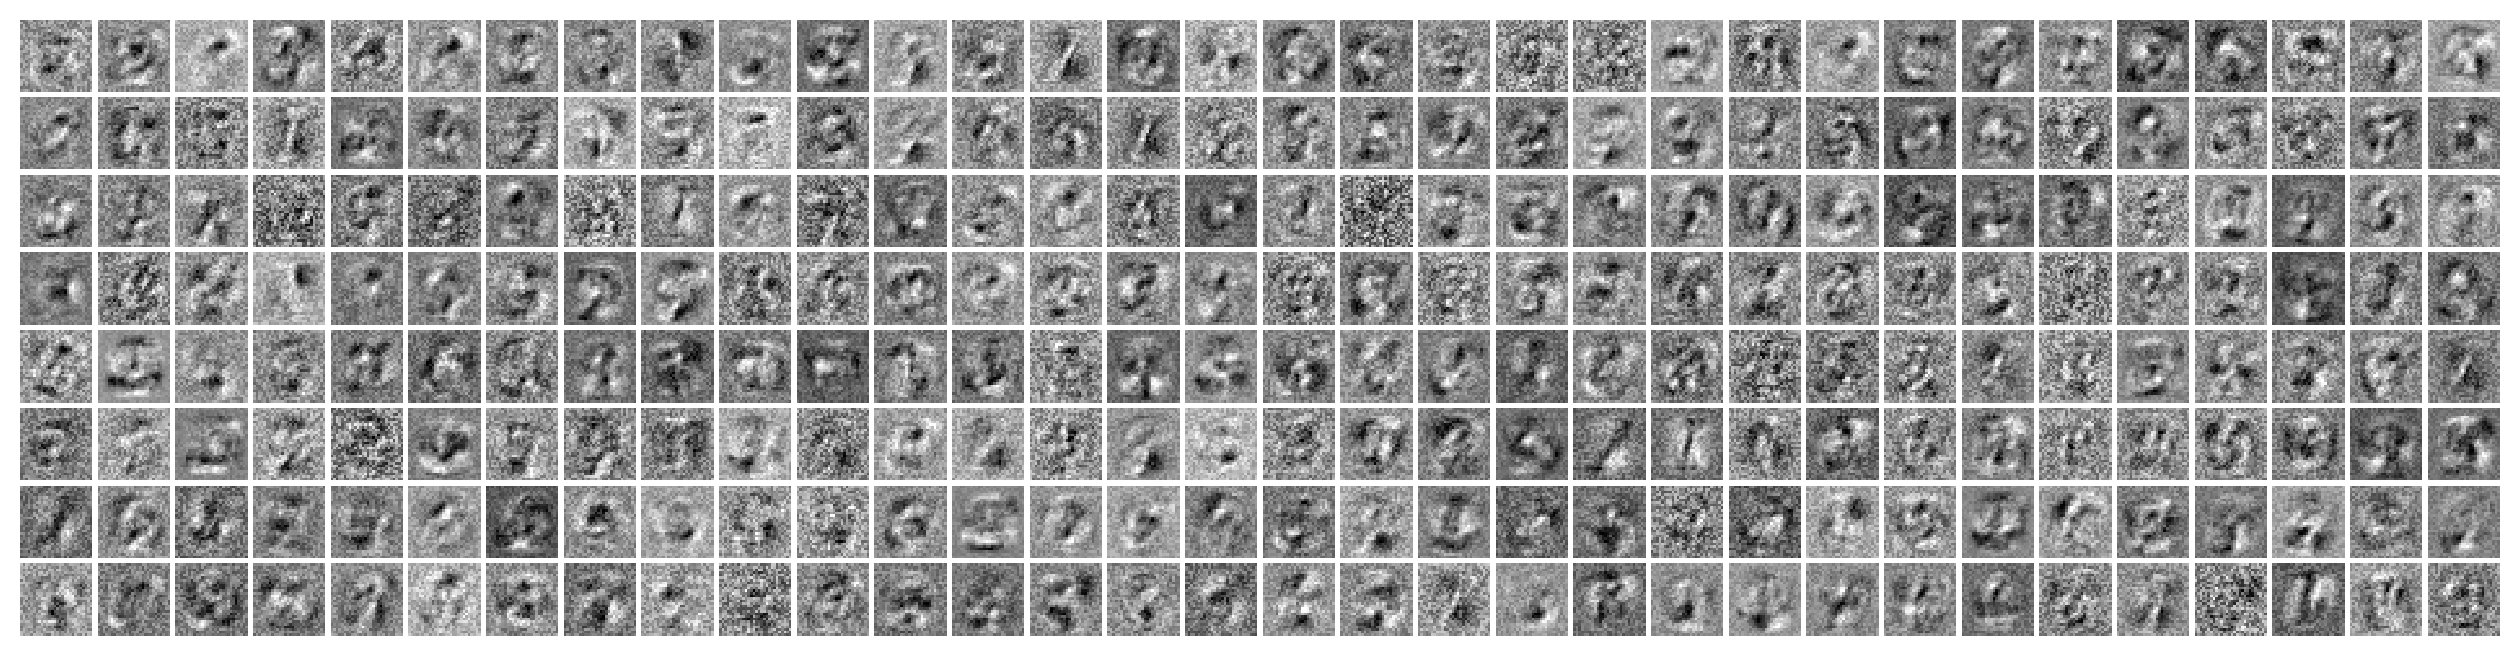

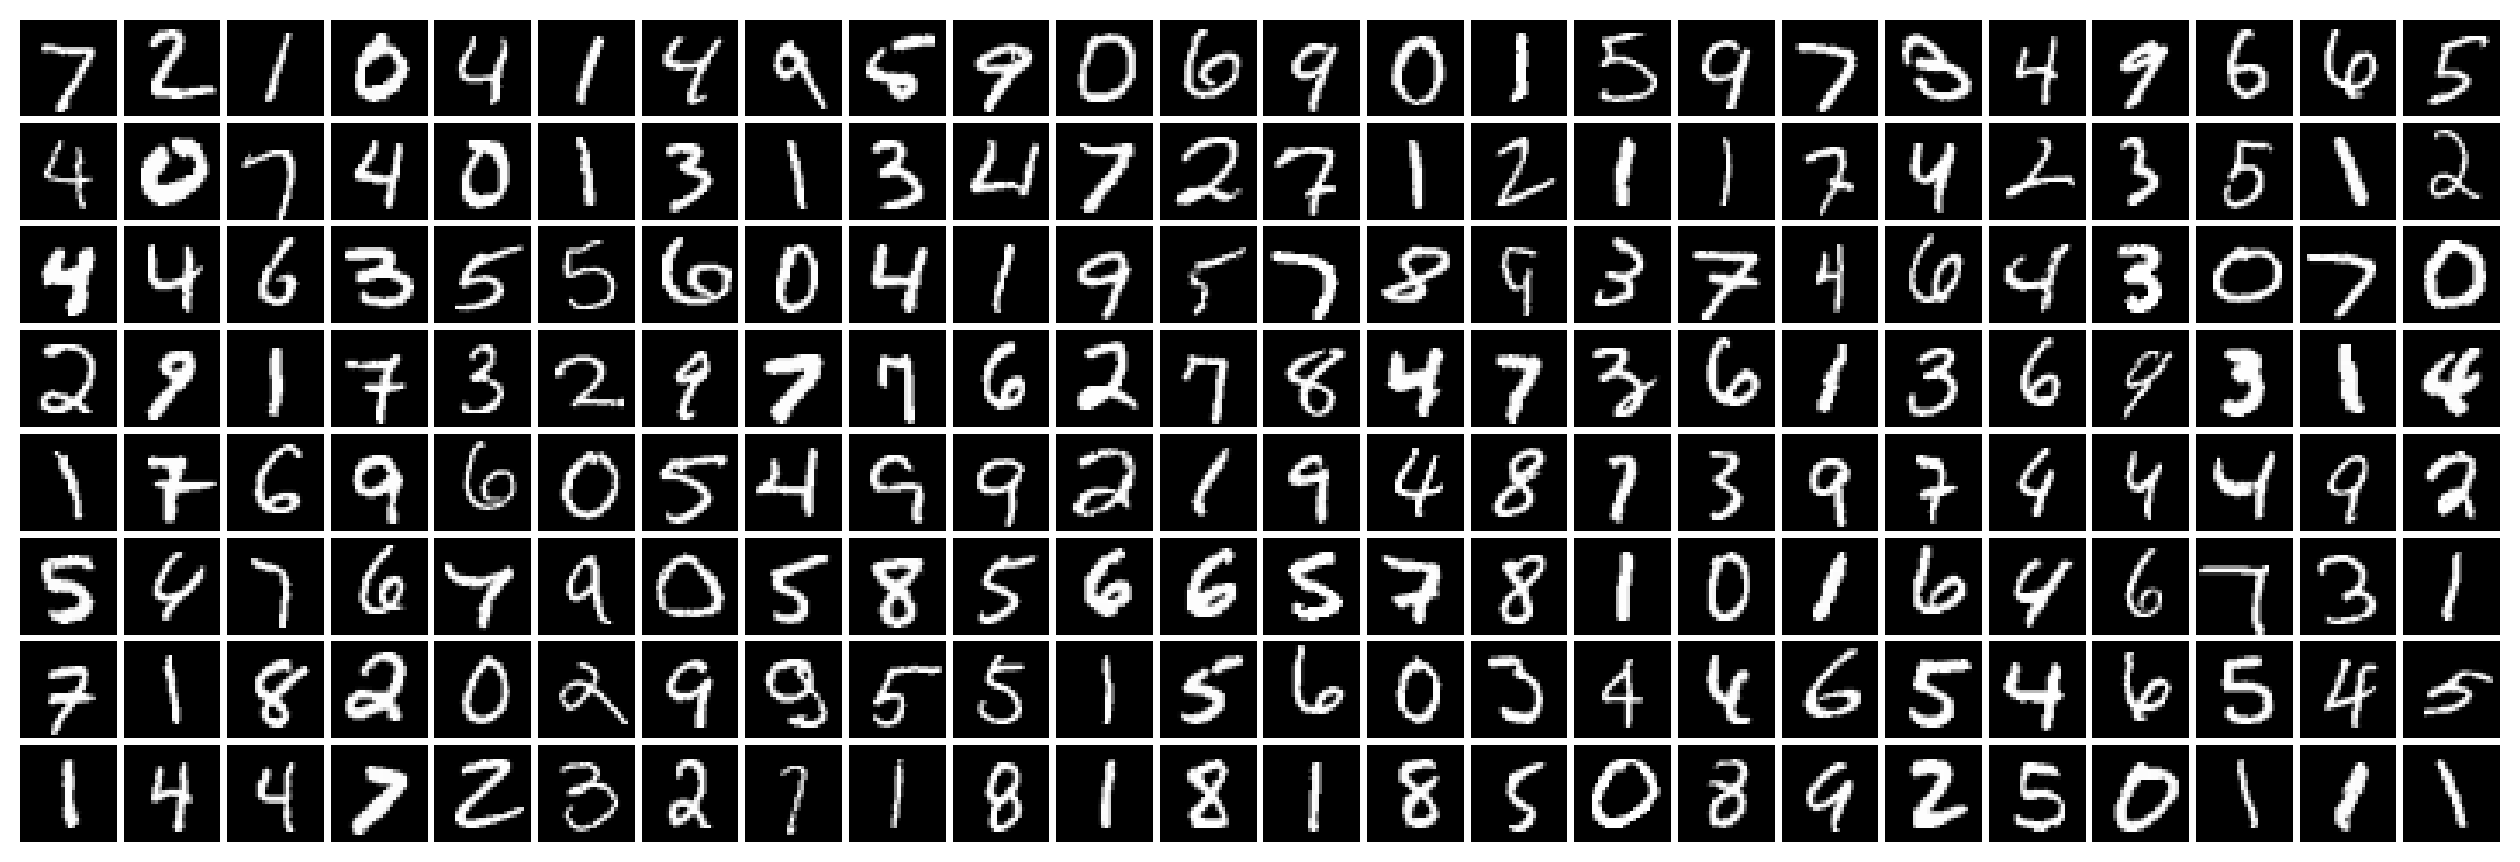

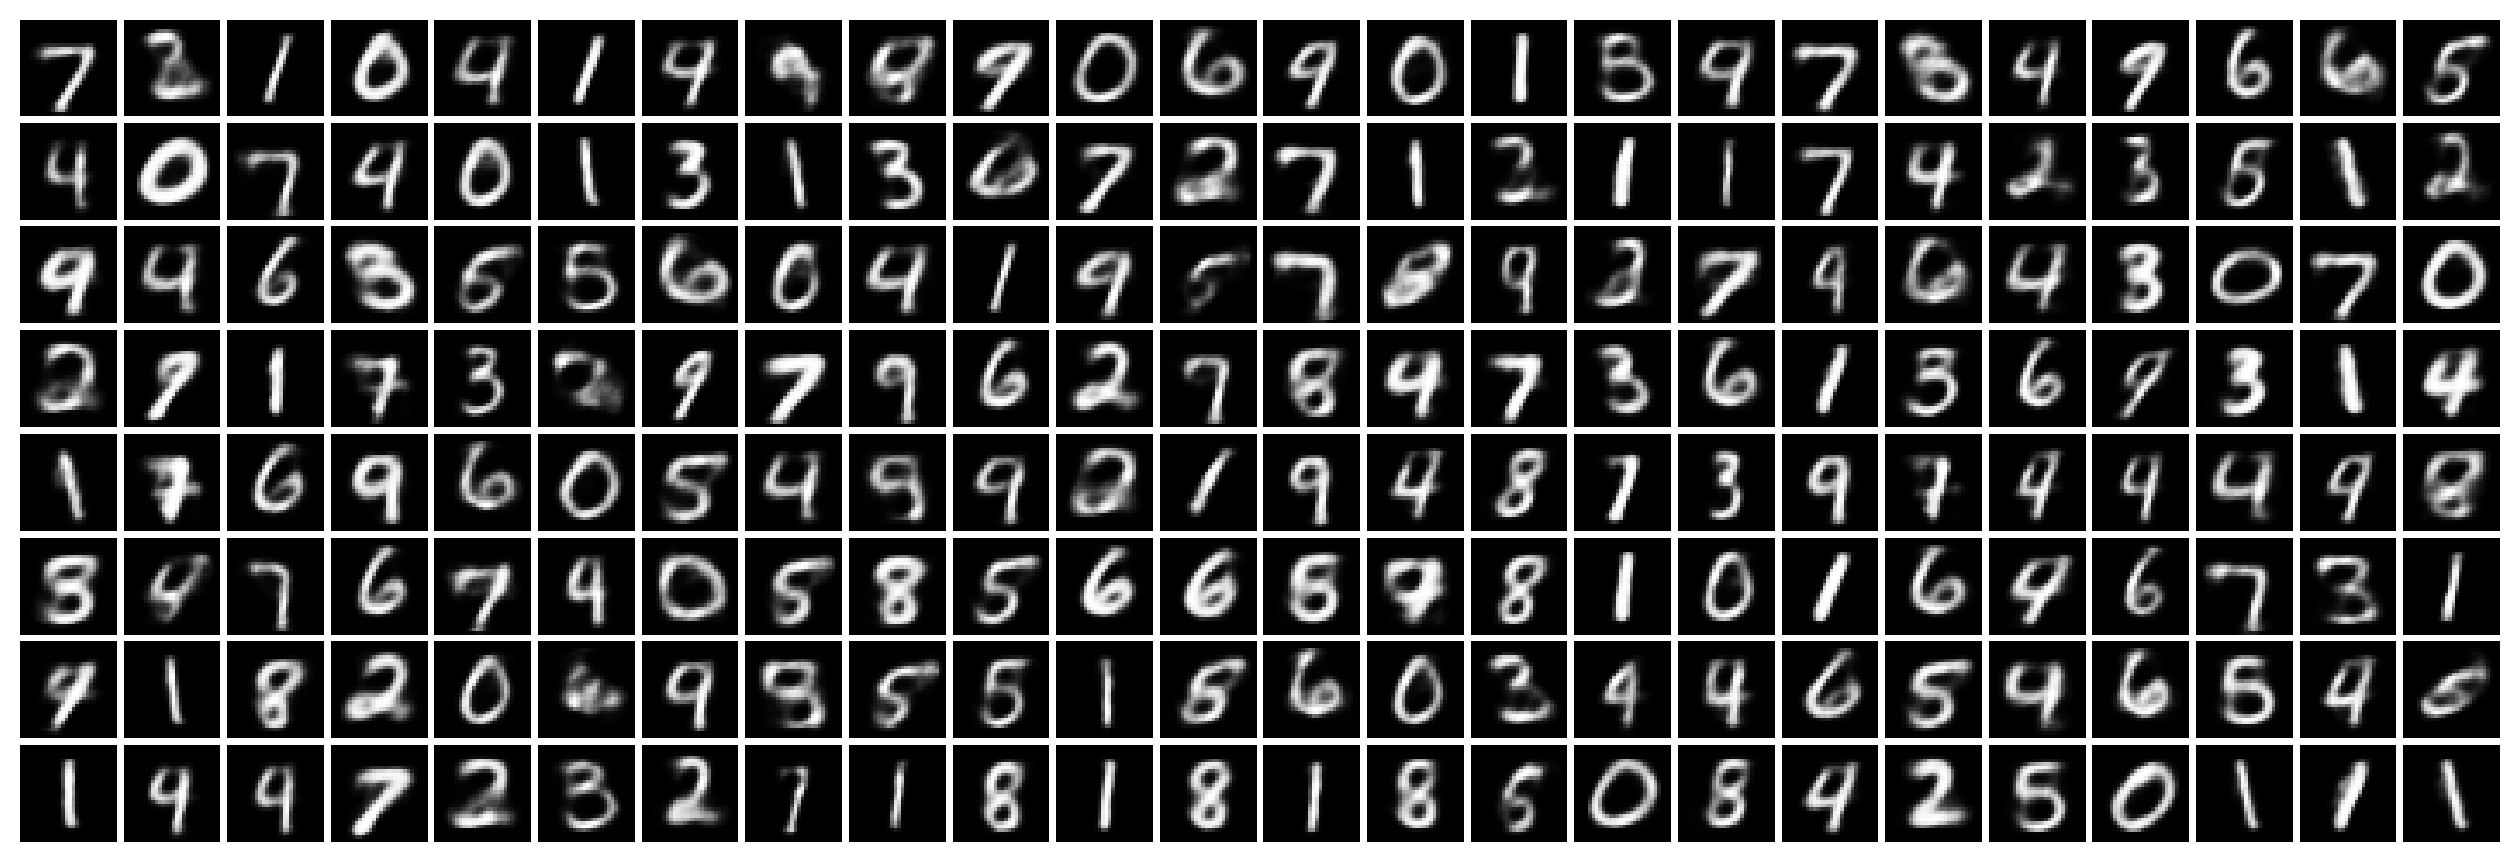


Learning layer 0
Epoch 1:	########################################	elapsed: 0.67s, reconstruction error: 20.70
Epoch 2:	########################################	elapsed: 0.64s, reconstruction error: 16.72
Epoch 3:	########################################	elapsed: 0.59s, reconstruction error: 14.78
Epoch 4:	########################################	elapsed: 0.53s, reconstruction error: 13.48
Epoch 5:	########################################	elapsed: 0.71s, reconstruction error: 12.76
Epoch 6:	########################################	elapsed: 0.57s, reconstruction error: 11.89
Epoch 7:	########################################	elapsed: 0.55s, reconstruction error: 11.04
Epoch 8:	########################################	elapsed: 0.56s, reconstruction error: 10.46
Epoch 9:	########################################	elapsed: 0.56s, reconstruction error: 10.05
Epoch 10:	########################################	elapsed: 0.59s, reconstruction error: 9.93
Epoch 11:	################################

Reconstruction cost before finetuning: 131.81

Epoch 1:	########################################	elapsed: 0.65s, cross-entropy: 101.11
Epoch 2:	########################################	elapsed: 0.76s, cross-entropy: 97.60
Epoch 3:	########################################	elapsed: 2.59s, cross-entropy: 95.77
Epoch 4:	########################################	elapsed: 0.61s, cross-entropy: 94.41
Epoch 5:	########################################	elapsed: 0.54s, cross-entropy: 93.27
Epoch 6:	########################################	elapsed: 0.78s, cross-entropy: 92.30
Epoch 7:	########################################	elapsed: 0.55s, cross-entropy: 91.49
Epoch 8:	########################################	elapsed: 0.52s, cross-entropy: 90.83
Epoch 9:	########################################	elapsed: 0.67s, cross-entropy: 90.27
Epoch 10:	########################################	elapsed: 0.54s, cross-entropy: 89.76
Epoch 11:	########################################	elapsed: 0.79s, cross-entropy:

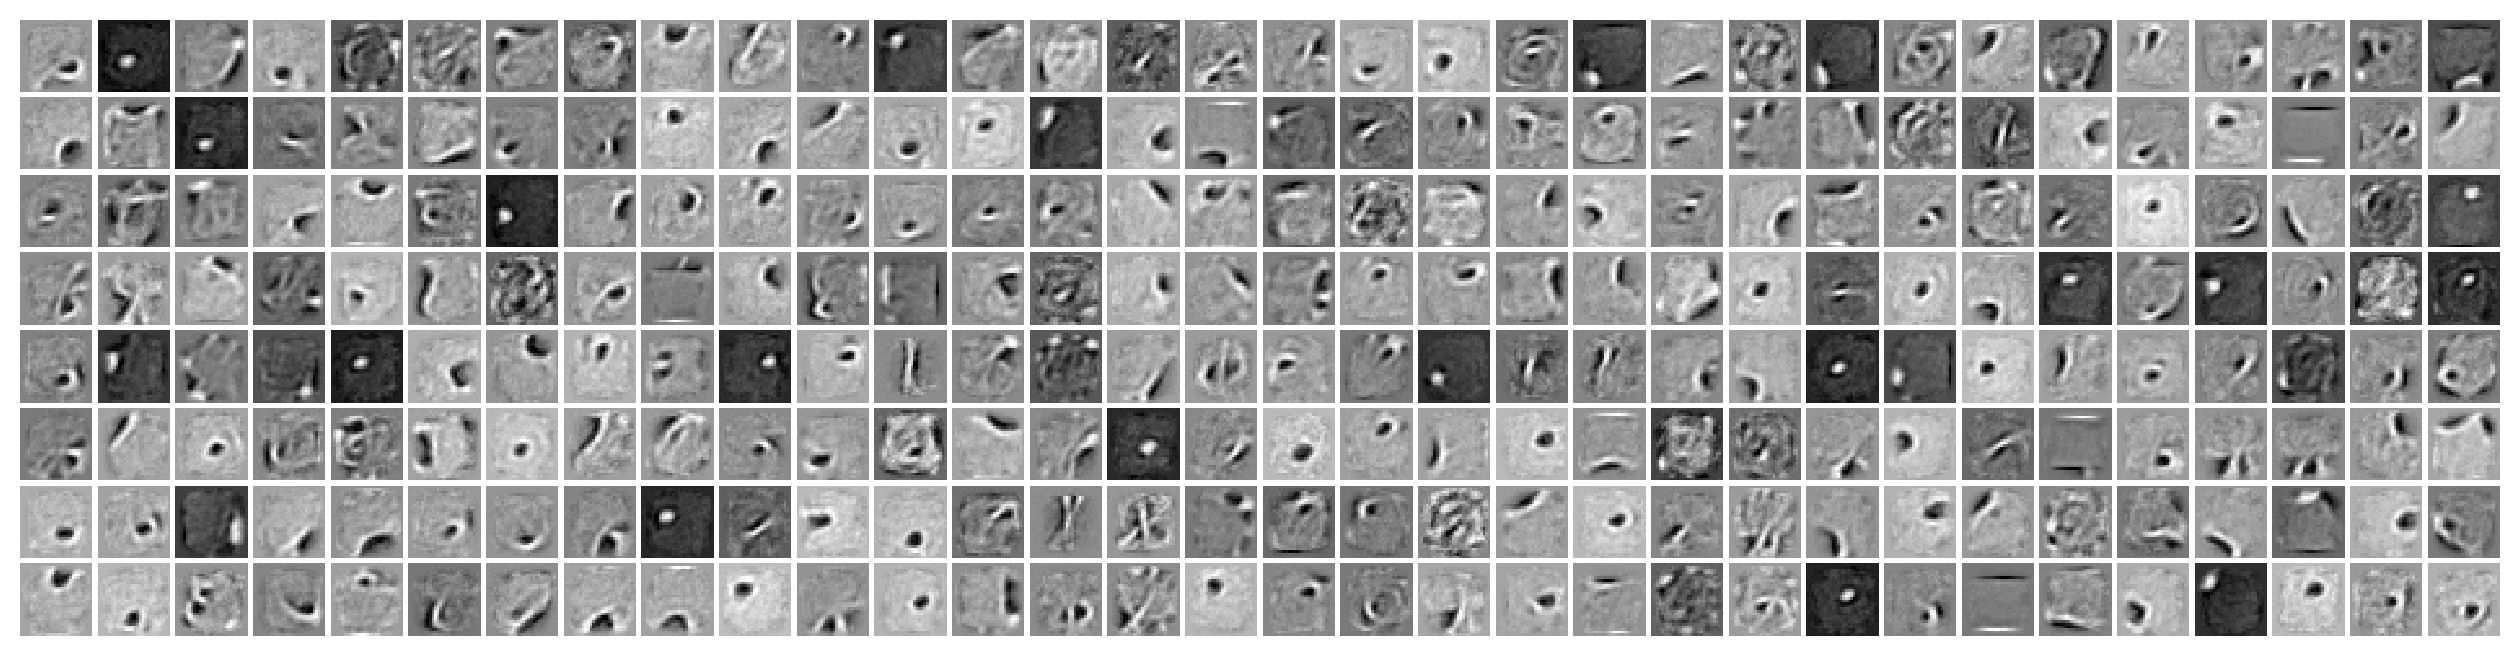

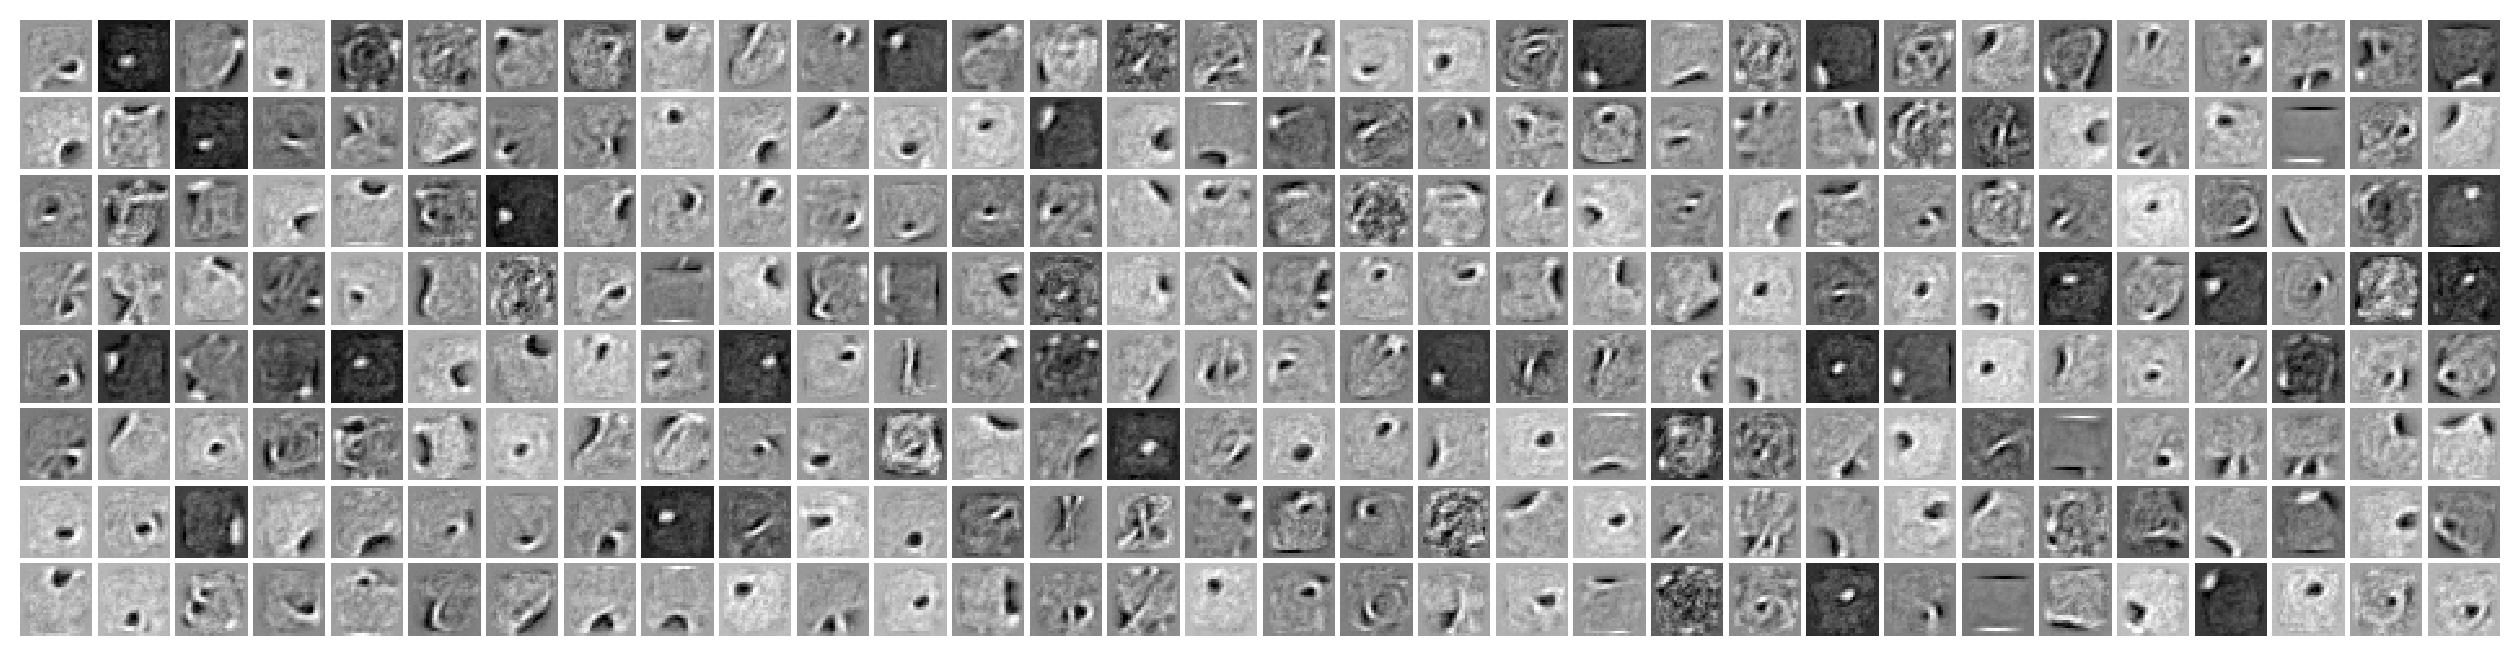

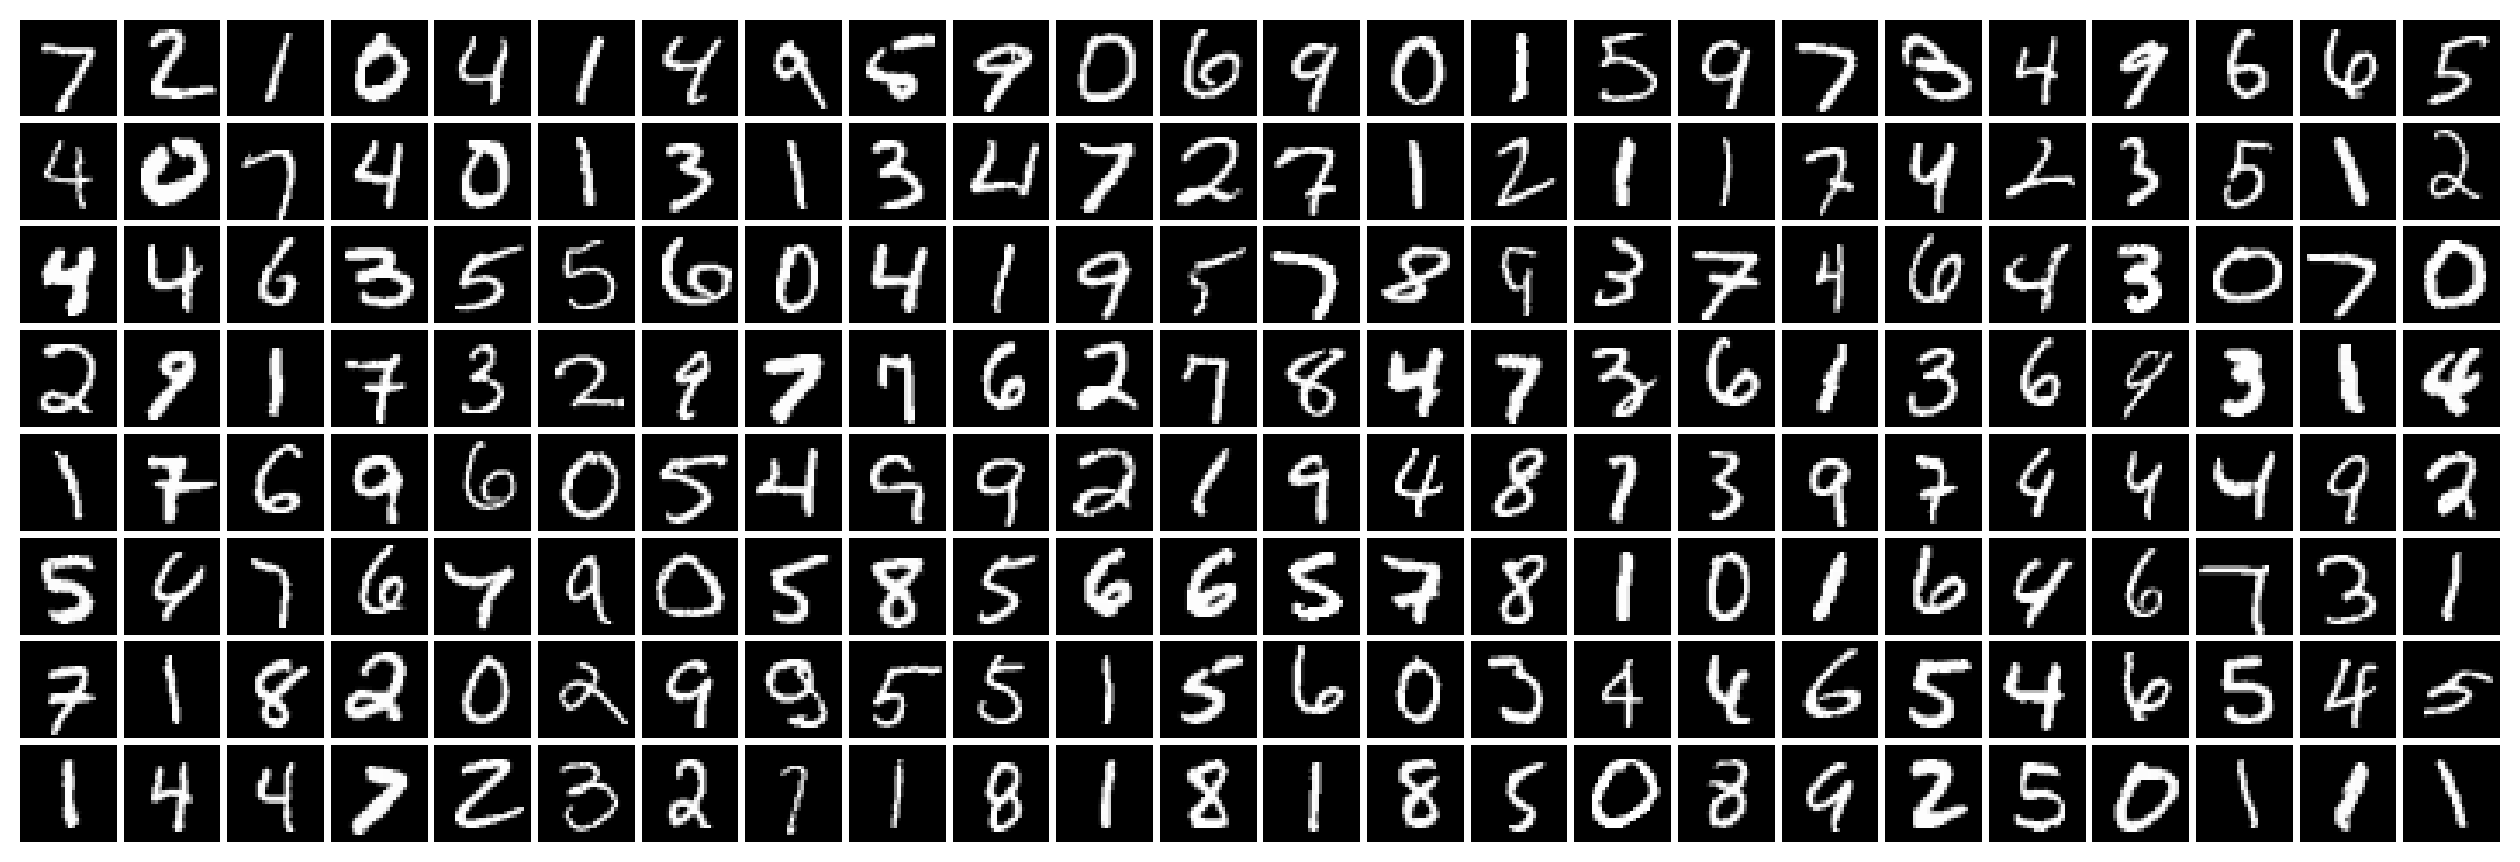

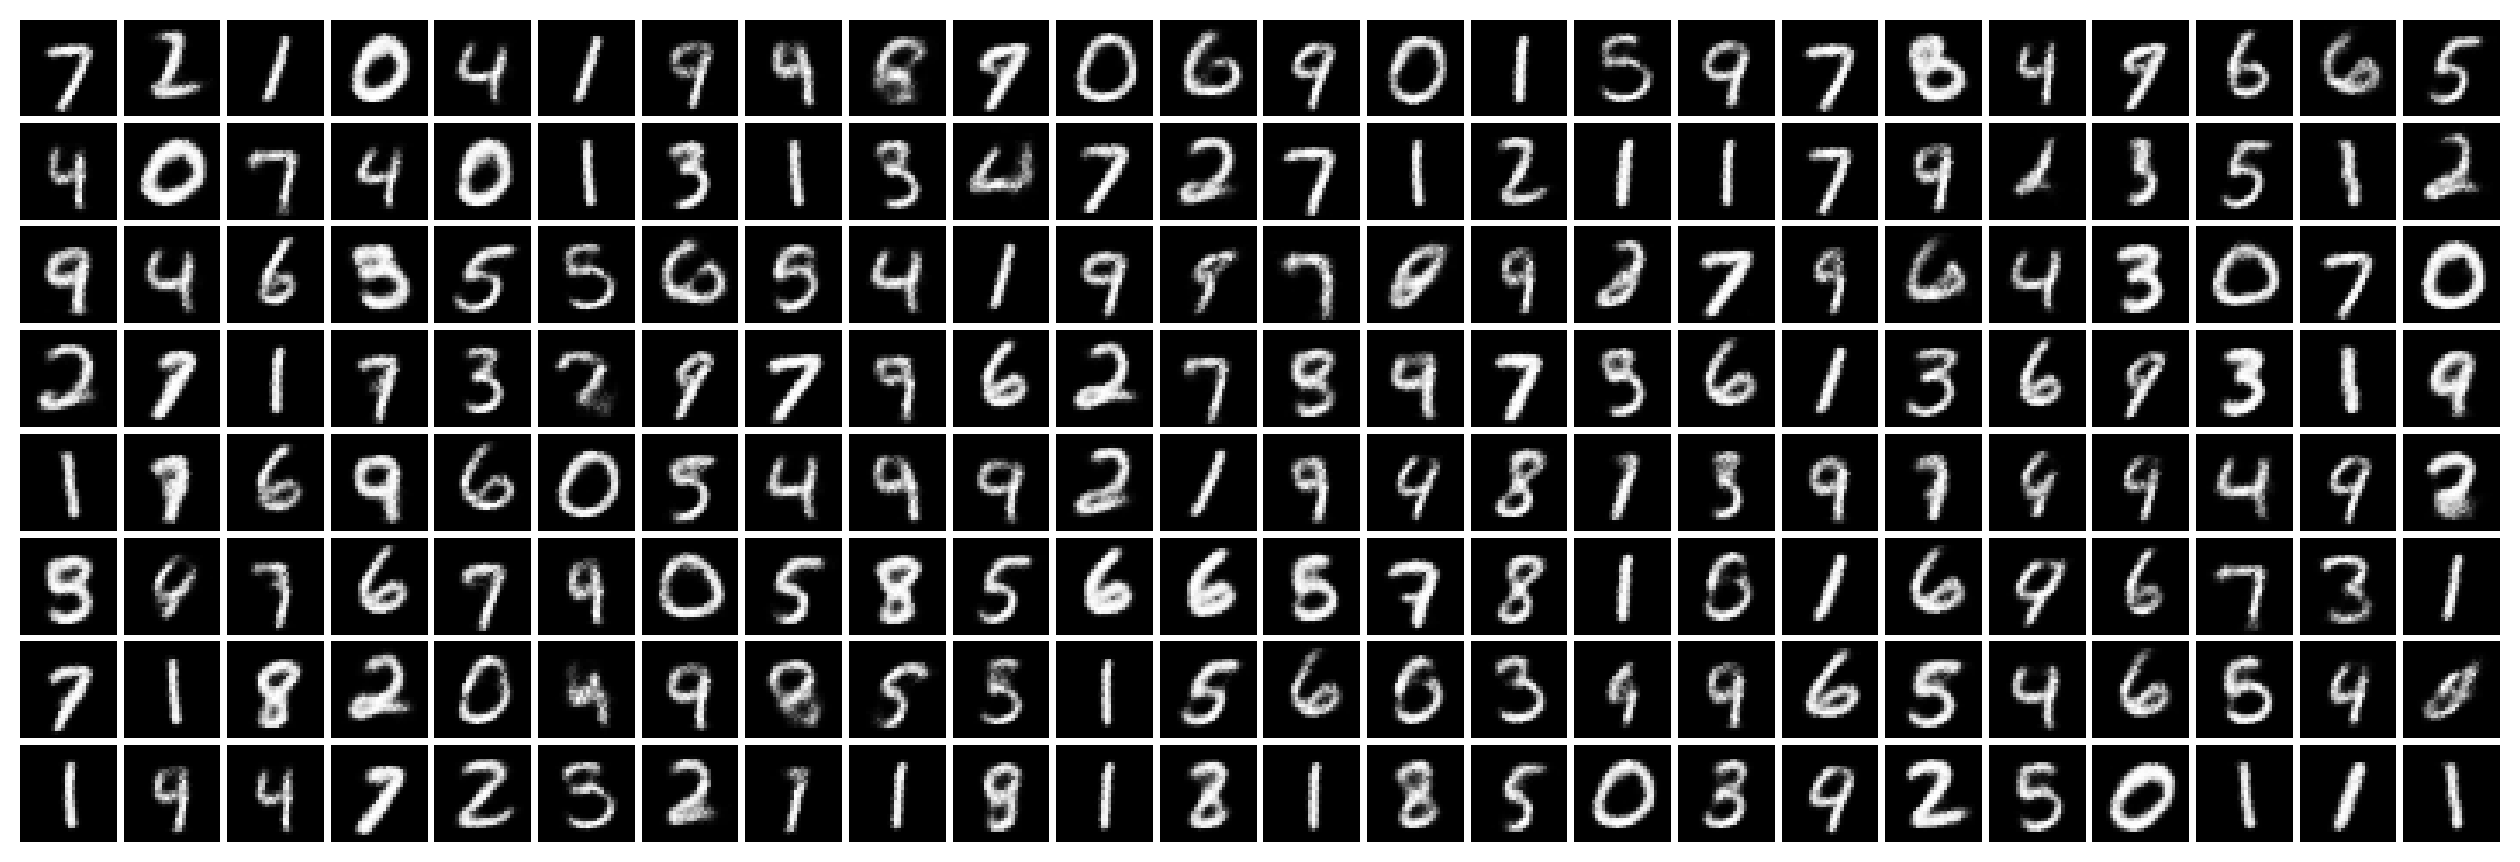

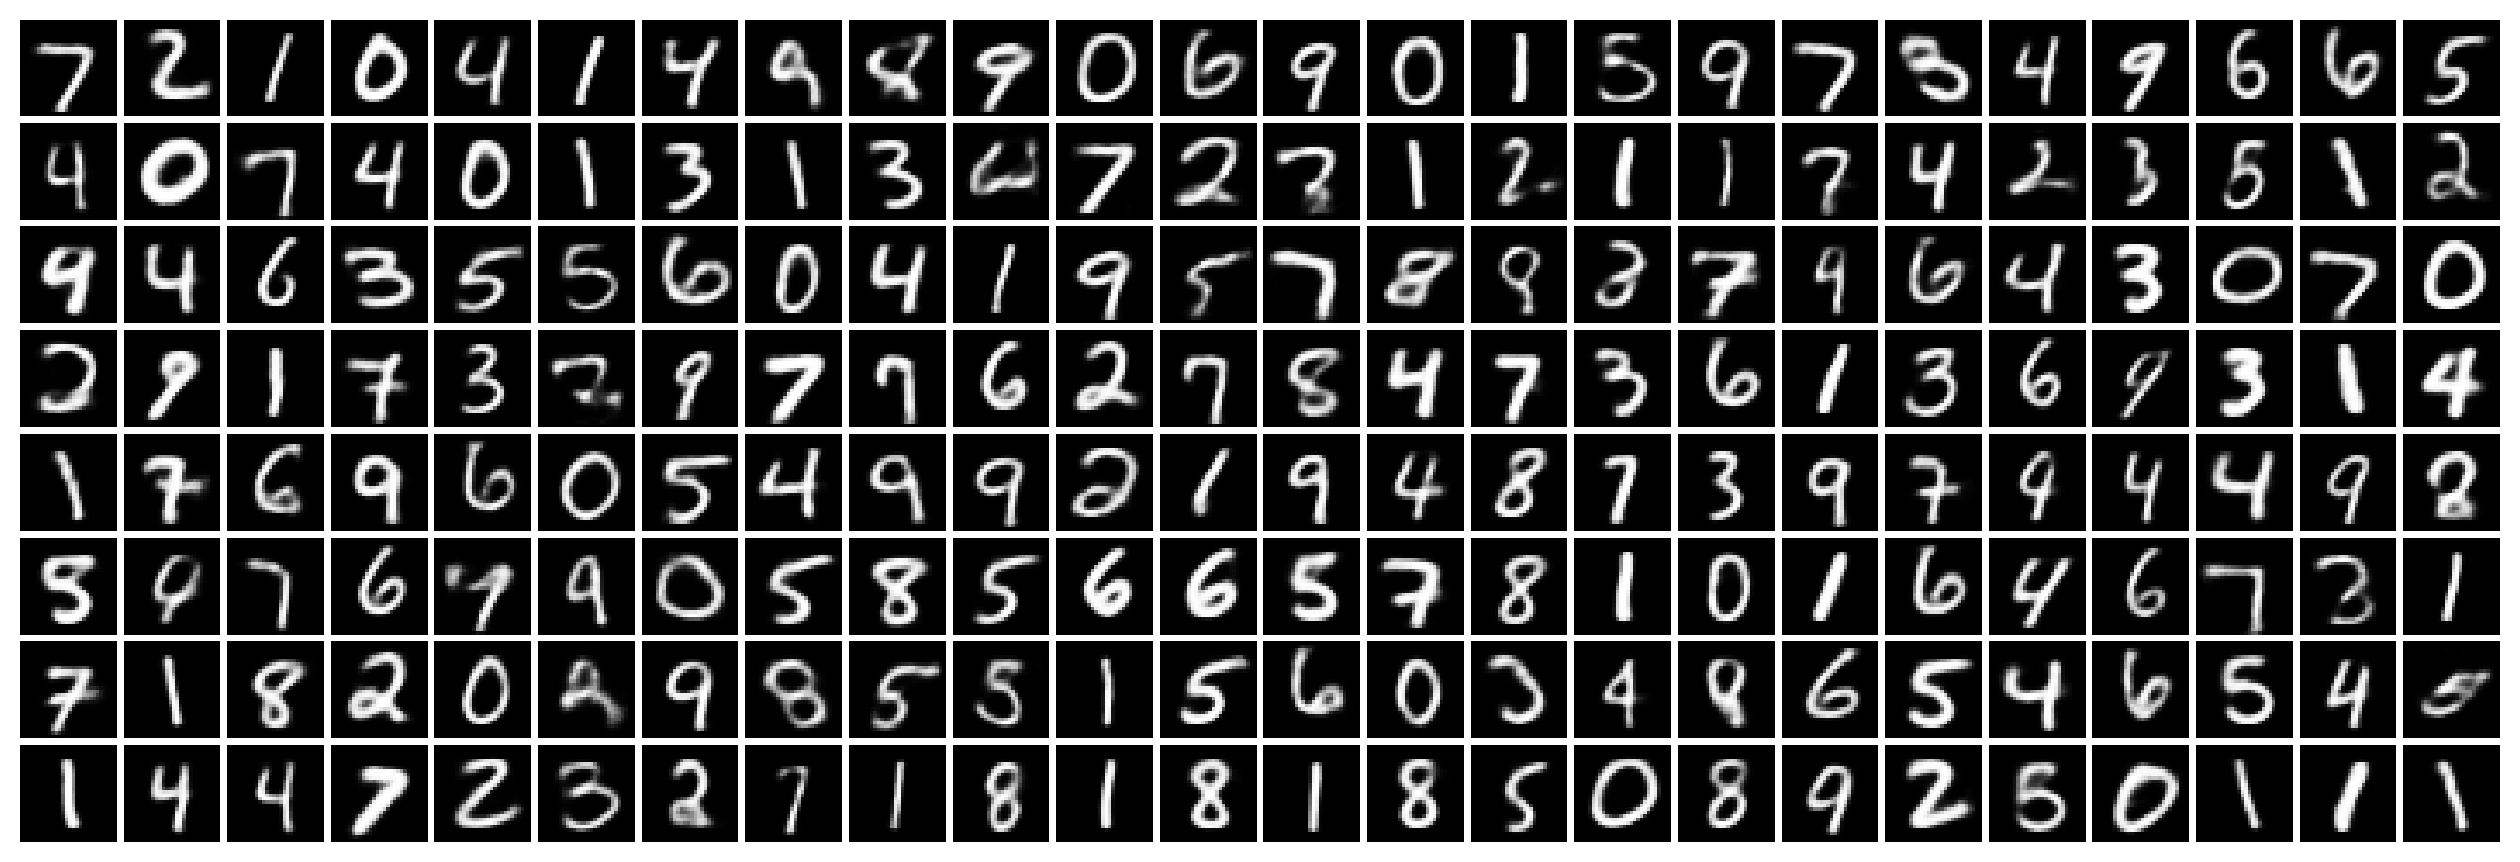

In [ ]:
dbn = [
    RBM(VISIBLE_LAYER_SIZE, 256, sigmoid, sigmoid, RBM_LEARNING_RATE, 0.5, L2_PENALTY, init_method="Xavier"),
    RBM(256, 128, sigmoid, sigmoid, RBM_LEARNING_RATE, 0.5, L2_PENALTY, init_method="Xavier"),
    RBM(128, 64, sigmoid, sigmoid, RBM_LEARNING_RATE, 0.5, L2_PENALTY, init_method="Xavier"),
    RBM(64, 10, sigmoid, gaussian, RBM_LEARNING_RATE / 10.0, 0.5, L2_PENALTY, init_method="Xavier"),
]


# raise Exception("AE structure is undefined!")
ae = [
    Linear(VISIBLE_LAYER_SIZE, 256, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY, init_method="Xavier"),
    Sigmoid(),
    Linear(256, 128, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY, init_method="Xavier"),
    Sigmoid(),
    Linear(128, 64, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY, init_method="Xavier"),
    Sigmoid(),
    Linear(64, 10, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY, init_method="Xavier"),
    #
    Linear(10, 64, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY, init_method="Xavier"),
    Sigmoid(),
    Linear(64, 128, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY, init_method="Xavier"),
    Sigmoid(),
    Linear(128, 256, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY, init_method="Xavier"),
    Sigmoid(),
    Linear(256, VISIBLE_LAYER_SIZE, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY, init_method="Xavier"),
]

compare_results(
    ae,
    dbn,
    mnist_train_images,
    mnist_test_images,
    monitoring_set,
    BATCH_SIZE,
    EPOCHS_COUNT,
)